In [1]:
%load_ext autoreload
%autoreload 2

from load_dataset import load_dataset
from models.nerf import NERF
from models.dense_voxel import DenseVoxel

from PIL import Image
import numpy as np
from tqdm import tqdm

import torch
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import time

from load_dataset import load_dataset
from render import render_rays_hierarchal, render_rays

device="cuda"

In [2]:
image_res = 100
image_size = image_res*image_res
(origins, dirs), colors = load_dataset("data/nerf_synthetic/lego/", image_res)


origins_test = origins[image_size*25:]
dirs_test = dirs[image_size*25:]
colors_test = colors[image_size*25:]

origins = origins[:image_size*25]
dirs = dirs[:image_size*25]
colors = colors[:image_size*25]

In [3]:
model = DenseVoxel().to(device)

In [4]:
origins = origins.to(device)
dirs = dirs.to(device)
colors = colors.to(device)
origins_test = origins_test.to(device)
dirs_test = dirs_test.to(device)
colors_test = colors_test.to(device)

In [5]:
def run_epoch(rays, colors, model, optimizer=None, bs=20000):
    origins, dirs = rays
    #dataset = TensorDataset(origins, dirs, colors)
    #loader = DataLoader(dataset, batch_size=bs, shuffle=(optimizer!=None))

    output_C = []
    losses = []

    #for b_origins, b_dirs, b_colors in loader:
    for i in range(0,len(origins), bs):
        b_origins = origins[i:i+bs]
        b_dirs = dirs[i:i+bs]
        b_colors = colors[i:i+bs]
        if optimizer is not None:
            optimizer.zero_grad()
        torch.cuda.synchronize()
        C_f = render_rays((b_origins, b_dirs), model, device=device)
        torch.cuda.synchronize()
        loss = F.mse_loss(b_colors, C_f)

        # reg = F.mse_loss(model.density_grid[1:,:,:], model.density_grid[:-1,:,:])
        # reg += F.mse_loss(model.density_grid[:,1:,:], model.density_grid[:,:-1,:])
        # reg += F.mse_loss(model.density_grid[:,:,1:], model.density_grid[:,:,:-1])
        # reg += F.mse_loss(model.color_grid[1:,:,:], model.color_grid[:-1,:,:])
        # reg += F.mse_loss(model.color_grid[:,1:,:], model.color_grid[:,:-1,:])
        # reg += F.mse_loss(model.color_grid[:,:,1:], model.color_grid[:,:,:-1])

        # loss += reg*0.001
        #C_f, C_c = render_rays_hierarchal((b_origins, b_dirs), model, model, device=device)
        #loss = F.mse_loss(b_colors, C_f) + F.mse_loss(b_colors, C_c)
        loss.backward()
        losses.append(loss.detach().cpu().numpy())

        if optimizer is not None:
            optimizer.step()
    
        output_C.append(C_f)

    return torch.cat(output_C, dim=0), np.mean(losses)

In [6]:
rays = (origins, dirs)

lrate_decay = 200
lrate = 0.02
optimizer = optim.RMSprop(model.parameters(), lr=lrate)

In [7]:
for i in range(1000):
    C, loss = run_epoch(rays, colors, model, optimizer)
    print(loss, i)
    if i%10==0:
        torch.save(model,"model")
    
        # decay_rate = 0.1
        # decay_steps = lrate_decay * 1000
        # new_lrate = lrate * (decay_rate ** (i / decay_steps))
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = new_lrate

C:\Python39\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.26296145 0
0.16238001 1
0.120714396 2
0.0980976 3
0.08428481 4
0.07514039 5
0.068729825 6
0.0640305 7
0.06046128 8
0.057676043 9
0.055452194 10
0.053642966 11
0.052147474 12
0.050894167 13
0.049832202 14
0.048927028 15
0.048136655 16
0.047451712 17
0.046850517 18
0.04632236 19
0.045856707 20
0.045433912 21
0.04505889 22
0.04472031 23
0.044415478 24
0.04413927 25
0.043888688 26
0.043662462 27
0.04345215 28
0.043258645 29
0.04308129 30
0.042920414 31
0.04277106 32
0.042636808 33
0.042505972 34
0.042392485 35
0.04228246 36
0.042183235 37
0.042089038 38
0.042003747 39
0.04192463 40
0.041847534 41
0.041779842 42
0.04171783 43
0.041657075 44
0.041604638 45
0.041548476 46
0.041502245 47
0.04145747 48
0.04141661 49
0.041377343 50
0.041340902 51
0.04130959 52
0.041273274 53
0.041246615 54
0.041220143 55
0.041196898 56
0.041165017 57
0.04114405 58
0.041124858 59
0.041105893 60
0.041086234 61
0.04107312 62
0.04105932 63
0.04103507 64
0.041026577 65
0.041011963 66
0.04099879 67
0.04099036 68
0.0

KeyboardInterrupt: 

got img


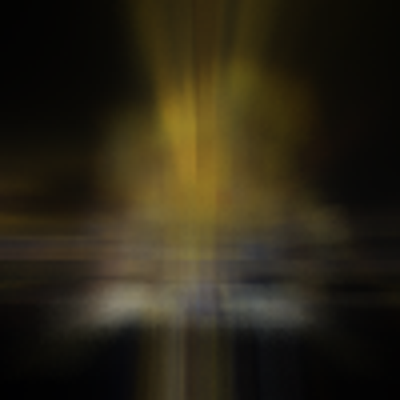

In [8]:
si = 0* image_size
ei = 1* image_size
C, loss = run_epoch(
    (origins[si:ei], dirs[si:ei]),
    colors[si:ei],
    model,
)
#C = colors[si:ei]
print("got img")
out_img = C.detach().cpu().numpy().reshape((image_res, image_res, 3))
Image.fromarray(np.uint8(np.clip((out_img) * 255, 0, 255))).resize((400,400))

In [ ]:
from load_dataset import c2w_to_rays

got img


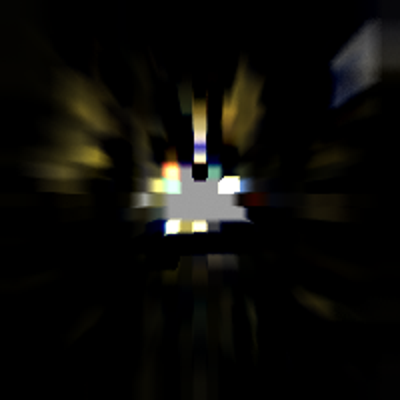

In [ ]:
from scipy.spatial.transform import Rotation as R

r = R.from_euler('x', 0, degrees=True).as_matrix()
r = R.from_euler('y', 0, degrees=True).as_matrix() @ r
r = R.from_euler('z', 0, degrees=True).as_matrix() @ r

c2w = np.eye(4)
c2w[:3,:3] = r
c2w = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1]
]) @ c2w

origins1, dirs1 = c2w_to_rays(c2w,200,200)
origins1 = torch.FloatTensor(origins1).to(device)
dirs1 = torch.FloatTensor(dirs1).to(device)

C, loss = run_epoch(
    (origins1, dirs1),
    torch.zeros_like(origins1),
    model,
)
print("got img")
out_img = C.detach().cpu().numpy().reshape((image_res, image_res, 3))
Image.fromarray(np.uint8(np.clip((out_img) * 255, 0, 255))).resize((400,400))

In [ ]:
c2w

array([[ 1.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.9998477 , -0.01745241,  1.        ],
       [ 0.        ,  0.01745241,  0.9998477 ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
import ipywidgets as widgets

t = widgets.Text(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)

def on_enter():
    print('enter key pressed')

t.on_submit(on_enter)